# Aprendizado Não-Supervisionado Avançado: Similaridade entre Aeronaves

Nesta aula, vamos explorar métodos avançados de aprendizado não-supervisionado e aplicar esses conceitos para entender a similaridade entre aeronaves. Vamos abordar tópicos como aprendizado não-supervisionado avançado, Metric Learning, técnicas de clustering avançadas, e como preparar um relatório de clustering.

## Objetivos
- Entender os conceitos de aprendizado não-supervisionado avançado e Metric Learning.
- Aprender a aplicar Metric Learning para avaliar a similaridade entre aeronaves.
- Explorar técnicas de clustering avançadas e sua aplicação.
- Analisar clusters e interpretar os resultados.
- Preparar um relatório detalhado sobre os clusters identificados e a análise realizada.


In [1]:
# Importações necessárias
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from typing import List, Tuple
import os

# Verificar se o CUDA está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definindo uma função para plotar os embeddings
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10, 10))
    for i in range(2):  # estamos usando 2 para representar duas classes, isso pode ser ajustado conforme necessário
        inds = np.where(targets == i)[0]
        plt.scatter(embeddings[inds, 0], embeddings[inds, 1], alpha=0.5)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.legend(targets.unique())
    plt.show()

# Placeholder para o caminho do arquivo, pois o arquivo real não foi fornecido.
# O usuário precisará substituir isso pelo caminho correto para o arquivo do dataset.
file_path = "../dados/aeronaves/FAA-Aircraft-Char-DB-AC-150-5300-13B-App-2023-09-07.csv"  # por favor, atualize com o caminho correto

# Carregar o dataset
data = pd.read_csv(file_path, sep=";", thousands=".", decimal=",")

# Visualizar as primeiras linhas do dataset para inspeção
print(data.head())


  ICAO_Code FAA_Designator Manufacturer              Model_FAA  \
0       A10            A10    FAIRCHILD          Fairchild A10   
1      A124           A124      ANTONOV  Antonov AN-124 Ruslan   
2      A19N           A19N       AIRBUS        Airbus A319 Neo   
3      A20N           A20N       AIRBUS        Airbus A320 Neo   
4      A21N           A21N       AIRBUS        Airbus A321 Neo   

           Model_BADA Physical_Class_Engine  Num_Engines AAC AAC_minimum  \
0     Fairchild A-10A                   Jet          2.0   C         NaN   
1  Antonov AN-124-100                   Jet          4.0   D         NaN   
2     Airbus A319 Neo                   Jet          2.0   C         NaN   
3    Airbus A320-271N                   Jet          2.0   C         NaN   
4    Airbus A321-251N                   Jet          2.0   C         NaN   

  AAC_maximum  ... Unnamed: 46 Unnamed: 47  Unnamed: 48  Unnamed: 49  \
0         NaN  ...         NaN         NaN          NaN          NaN   
1 

In [2]:
# Selecione as colunas de características e labels
feature_columns = [
    'Wingspan_ft_without_winglets_sharklets', 'Length_ft', 'Tail_Height_at_OEW_ft', 
    'Wheelbase_ft', 'Main_Gear_Width_ft', 'Approach_Speed_knot', 'MTOW_lb', 'MALW_lb',
    'Num_Engines', 'Manufacturer', 'Main_Gear_Config', 'ICAO_Code'
]
label_column = 'Physical_Class_Engine'

data = data[feature_columns+[label_column]]
data = data.dropna()

In [3]:
data

,Wingspan_ft_without_winglets_sharklets,Length_ft,Tail_Height_at_OEW_ft,Wheelbase_ft,Main_Gear_Width_ft,Approach_Speed_knot,MTOW_lb,MALW_lb,Num_Engines,Manufacturer,Main_Gear_Config,ICAO_Code,Physical_Class_Engine
1,240.5,226.2,68.2,78.9,33.0,151.0,892871.0,727525.0,4.0,ANTONOV,5D,A124,Jet
5,147.1,177.4,54.7,61.0,36.0,137.0,363760.0,304230.0,2.0,AIRBUS,2D,A306,Jet
6,147.1,175.5,54.9,60.8,36.1,137.0,363760.0,299829.0,2.0,AIRBUS,2D,A30B,Jet
7,144.0,153.2,52.3,49.9,36.0,139.0,317465.0,273372.0,2.0,AIRBUS,2D,A310,Jet
8,111.9,103.2,42.3,33.6,29.4,121.0,149914.0,126766.0,2.0,AIRBUS,D,A318,Jet
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,41.6,34.9,14.3,9.6,12.7,85.0,7394.0,7024.0,1.0,SOCATA,S,TBM8,Turboprop
382,42.1,35.2,14.3,9.6,12.7,85.0,7394.0,7024.0,1.0,SOCATA,S,TBM9,Turboprop
383,33.4,33.2,10.7,7.7,9.7,103.0,6500.0,6900.0,1.0,RAYTHEON,S,TEX2,Turboprop
384,32.8,25.4,9.9,6.5,8.4,65.0,2530.0,2530.0,1.0,SOCATA,S,TOBA,Piston


In [4]:
#separar features e labels
features = data[feature_columns]
labels = data[label_column]

# Codificar labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Normalizar características
# Scandard Scaler nas numericas e Ordinal Encoder nas categoricas

# Selecionar colunas numéricas
numeric_columns = [
    'Wingspan_ft_without_winglets_sharklets', 'Length_ft', 'Tail_Height_at_OEW_ft', 
    'Wheelbase_ft', 'Main_Gear_Width_ft', 'Approach_Speed_knot', 'MTOW_lb', 'MALW_lb',
    'Num_Engines'
]

# Selecionar colunas categóricas
categorical_columns = [
    'Manufacturer', 'Main_Gear_Config', 'ICAO_Code'
]

# Normalizar colunas numéricas
scaler = StandardScaler()
features_numeric = scaler.fit_transform(features[numeric_columns])

# Codificar colunas categóricas
cat_encoder = OrdinalEncoder()
features_categorical = cat_encoder.fit_transform(features[categorical_columns])

# Juntar colunas numéricas e categóricas
features_normalized = np.concatenate([features_numeric, features_categorical], axis=1)


# Dividir os dados em conjuntos de treinamento e teste
features_train, features_test, labels_train, labels_test = train_test_split(
    features_normalized, labels_encoded, test_size=0.1, random_state=42
)

# Converter em tensores PyTorch
features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.long)
features_test_tensor = torch.tensor(features_test, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.long)

# Criar DataLoaders para treinamento e teste
train_dataset = torch.utils.data.TensorDataset(features_train_tensor, labels_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(features_test_tensor, labels_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [5]:
class ContrastiveEmbeddingNet(nn.Module):
    def __init__(self, n_features, n_embeddings):
        super(ContrastiveEmbeddingNet, self).__init__()
        self.fc = nn.Linear(n_features, 32)
        self.fc2 = nn.Linear(32, 32)
        self.relu = nn.ReLU()
        self.embeddings = nn.Linear(32, n_embeddings)
        
    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.embeddings(x)
        return x

# Definir a função de perda contrastiva
# Esta função de perda tenta garantir que exemplos da mesma classe estejam próximos no espaço de embedding,
class SupConLoss(nn.Module):
    """
    From https://github.com/HobbitLong/SupContrast/blob/master/losses.py
    Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the selfsupervised contrastive loss in SimCLR
    """

    def __init__(
        self, temperature=0.07, contrast_mode="all", base_temperature=0.07, eps=1e-15
    ):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.eps = eps

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR selfsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = torch.device("cuda") if features.is_cuda else torch.device("cpu")

        if len(features.shape) < 3:
            raise ValueError(
                "`features` needs to be [bsz, n_views, ...],"
                "at least 3 dimensions are required"
            )
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size, contrast_count, _ = features.shape
        if labels is not None and mask is not None:
            raise ValueError("Cannot define both `labels` and `mask`")
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32, device=device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError("Num of labels does not match num of features")
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        # n_views x batch_size, ...
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == "one":
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == "all":
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise NotImplementedError("Unknown mode: {}".format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T), self.temperature
        )
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        # (batch_size, batch_size) -> (n_views x batch_size, n_views x batch_size)
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask, device=device),
            1,
            torch.arange(batch_size * anchor_count, device=device).view(-1, 1),
            0,
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = (torch.exp(logits) + self.eps) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + self.eps)

        # loss
        loss = -(self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss
# Instanciar o modelo e a função de perda
n_features = features_normalized.shape[1]
n_embeddings = 2  # para propósitos de visualização, estamos usando 2 embeddings
model = ContrastiveEmbeddingNet(n_features, n_embeddings).to(device)
criterion = SupConLoss(temperature=0.07, contrast_mode="all")

# Definir o otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [6]:
def train_and_capture_embeddings(model, criterion, optimizer, train_loader, test_loader, n_epochs=25):
    # Para armazenar os embeddings de todas as épocas
    embeddings_over_time = []
    
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        
        for batch_idx, (features, labels) in enumerate(train_loader):
            features, labels = features.to(device), labels.to(device)
            
            # Zerar os gradientes
            optimizer.zero_grad()
            
            # Forward pass para obter os embeddings
            embeddings = model(features)
            
            # Calcular a perda. A função SupConLoss espera que os embeddings tenham uma dimensão extra 
            # correspondente ao número de 'views' (geralmente usado para dados aumentados). 
            # Como não estamos usando múltiplas views, adicionamos uma dimensão extra.
            embeddings = embeddings.unsqueeze(1)

            # Calcular a perda contrastiva
            loss = criterion(embeddings, labels)

            # Backward pass e otimização
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss/len(train_loader):.4f}')
        
        # Capturar embeddings após cada época
        model.eval()
        with torch.no_grad():
            all_embeddings = []
            all_labels = []
            for features, labels in test_loader:
                features = features.to(device)
                embeddings = model(features).cpu().numpy()
                all_embeddings.append(embeddings)
                all_labels.append(labels.numpy())  # labels são convertidas para numpy para futura visualização
            # Adicionando embeddings da época atual à lista
            embeddings_over_time.append((np.vstack(all_embeddings), np.hstack(all_labels)))
    
    return embeddings_over_time

# Treinar o modelo e capturar embeddings
embeddings_over_time = train_and_capture_embeddings(model, criterion, optimizer, train_loader, test_loader, n_epochs=50)


Epoch [1/50], Loss: 3723.2053
Epoch [2/50], Loss: 2721.0796
Epoch [3/50], Loss: 2171.0865
Epoch [4/50], Loss: 1647.3572
Epoch [5/50], Loss: 1229.2914
Epoch [6/50], Loss: 889.3041
Epoch [7/50], Loss: 668.8928
Epoch [8/50], Loss: 512.9959
Epoch [9/50], Loss: 362.4933
Epoch [10/50], Loss: 265.6900
Epoch [11/50], Loss: 187.9377
Epoch [12/50], Loss: 124.6027
Epoch [13/50], Loss: 87.0145
Epoch [14/50], Loss: 57.4200
Epoch [15/50], Loss: 39.2493
Epoch [16/50], Loss: 26.4074
Epoch [17/50], Loss: 18.5528
Epoch [18/50], Loss: 13.4483
Epoch [19/50], Loss: 10.6013
Epoch [20/50], Loss: 8.0863
Epoch [21/50], Loss: 6.3856
Epoch [22/50], Loss: 5.4345
Epoch [23/50], Loss: 4.6610
Epoch [24/50], Loss: 4.1484
Epoch [25/50], Loss: 3.9349
Epoch [26/50], Loss: 3.5170
Epoch [27/50], Loss: 3.3356
Epoch [28/50], Loss: 3.2541
Epoch [29/50], Loss: 3.0032
Epoch [30/50], Loss: 2.9033
Epoch [31/50], Loss: 2.9224
Epoch [32/50], Loss: 2.8790
Epoch [33/50], Loss: 2.8292
Epoch [34/50], Loss: 2.8283
Epoch [35/50], Loss: 

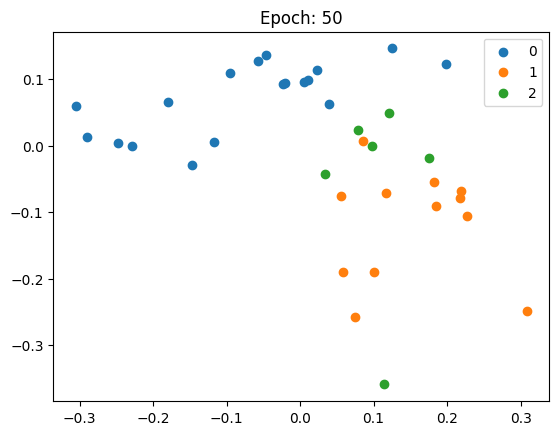

In [7]:
from IPython.display import HTML
import matplotlib.animation as animation

# Função para criar animação
def create_animation(embeddings_over_time):
    fig, ax = plt.subplots()
    
    def update(epoch):
        ax.clear()
        # Neste ponto, embeddings e labels são uma tupla para a época específica
        embeddings, labels = embeddings_over_time[epoch]
        for label in np.unique(labels):
            inds = labels == label
            ax.scatter(embeddings[inds, 0], embeddings[inds, 1], label=label)
        ax.legend()
        ax.set_title(f"Epoch: {epoch+1}")

    ani = animation.FuncAnimation(fig, update, frames=len(embeddings_over_time), repeat=True)
    
    # Isso é necessário para visualizar a animação no Jupyter Notebook
    return HTML(ani.to_jshtml())

# Chamar a função de animação
animation_html = create_animation(embeddings_over_time)

In [8]:
animation_html